# Benchmarking QN-SPSA optimizer with Amazon Braket Hybrid Jobs and embedded simulators

This notebook demonstrates how to implement and benchmark the QN-SPSA optimizer, a novel quantum optimization algorithm proposed by Gacon et al. [1]. Following this example, we will show how you can use Amazon Braket Hybrid Jobs to iterate faster on variational algorithm research, discuss best practices, and help you scale up your simulations with embedded simulators. 

## Introduction on Hybrid Jobs and embedded simulators
Amazon Braket Hybrid Jobs simplifies the process of setting up, monitoring, and efficiently executing hybrid quantum-classical algorithms and it helps you conduct systematic and reproducible quantum experiments on Amazon Braket. Hybrid Jobs are fully managed, which means you only need to provide your algorithm as a script, select the quantum device you want to run on, and then submit your job. Amazon Braket will spin up the requested classical compute (i.e., the job instance) to run your algorithm script, and manage the execution of quantum tasks on the selected device. You can select all QPUs and on-demand simulators (i.e. [SV1](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/quantum-simulator/amazon/sv1), [DM1](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/quantum-simulator/amazon/dm1), and [TN1](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/quantum-simulator/amazon/tn1)) as the target device of your algorithm, or run simulations directly on the job instance using _embedded simulators_, such as, PennyLane's `lighting.qubit` and `lighting.gpu`.  Embedded simulators benefit from lower latency compared to on-demand simulators, whereas on-demand simulators allow you to run many tasks in parallel. 

You can learn more about embedded simulators in [this example notebook](../4_Embedded_simulators_in_Braket_Jobs/Embedded_simulators_in_Braket_Jobs.ipynb).

## Background

### Variational quantum algorithms
Variational quantum algorithms (VQAs) are promising approaches in the noisy intermediate-scale quantum (NISQ) era, as they utilize classical computational resources to iteratively find solutions to the problem at hand and usually require only relatively shallow circuits to execute on the QPU. In VQA, you encode the quantity of interest as the ground state energy of a problem Hamiltonian. The algorithm can be then considered as a close-loop optimization process, where the loss function is defined by the expectation value of the Hamiltonian, while the circuit ansatz is parameterized with a set of classical parameters. With gradients (and possibly other metrics) measured from the quantum devices, an optimizer, such as gradient descent, is used to find the best parameters minimizing the loss.

### QN-SPSA optimizer

The update rule of a vanilla gradient descent (GD) is written as:

\begin{equation}
x^{(t + 1)} = x^{(t)} - \eta \nabla f(x^{(t)}) \tag{1}.
\end{equation}


For quantum circuits, the gradient $\nabla f(x^{(t)})$ is then estimated dimension by dimension, requiring $O(d)$ quantum measurements ($d$ being the dimension of the parameter space). As quantum measurements are expensive, this scaling makes GD impractical when dealing with high-dimensional complicated circuits.

SPSA replaces this dimension-wise gradient estimation with a stochastic one [2]. In SPSA, a randomly sampled direction is used to provide a finite-difference approximation on the gradient. Although this stochastic approach cannot provide a step-wise unbiased gradient estimation, SPSA is proved to be especially effective when accumulated over multiple optimization steps.

On the other hand, quantum natural gradient descent (QNG) is a variant of gradient descent. It introduces the Fubini-Study metric tensor $g$ [4] into the optimization to account for the structure of the non-Euclidean parameter space [5]. The $d$-by-$d$ metric tensor is defined as

$$
g_{ij} = -\frac{1}{2} \frac{\partial}{\partial x_i} \frac{\partial}{\partial x_j} \bigr\rvert\langle \phi(x') | \phi(x) \rangle \bigr\rvert ^ 2\biggr\rvert_{x'=x},\tag{2}
$$

where $\phi(x)$ is the parameterized ansatz with parameters $x$. With the metric tensor, the update rule is rewritten as:

\begin{align}
x^{(t + 1)} = x^{(t)} - \eta g^{-1}\nabla f(x^{(t)}) \tag{3}.
\end{align}

While the introduction of the metric tensor helps the optimization [3], the algorithm is not as scalable due to the number of measurements required to estimate $g$.


In a hand-waving argument, quantum natural simultaneous perturbation stochastic approximation (QN-SPSA, proposed by Gacon et al. [1]) is a second-order SPSA algorithm. QN-SPSA combines the merits of both QNG and SPSA by generalizing SPSA to second order and estimating both the gradient and the metric tensor stochastically. The gradient is estimated in the same fashion as the SPSA algorithm, while the Fubini-Study metric is computed by a second-order process with another two pairs of stochastic perturbations. QN-SPSA then executes a constant number of circuits per optimization step (2 for the gradient, 4 for the metric tensor). This $O(1)$ update rule is well suited for NISQ devices.

Let's take a look how QN-SPSA can be implemented with PennyLane and Braket.

## Notebook dependencies

<div class="alert alert-block alert-info">
<b>Note:</b> This notebook requires the following packages to execute. It is confirmed to work with: 
   <ul>
    <li>Pennylane version <b>0.22.0</b> (or later)</li>
    <li>Braket SDK version <b>1.20.0</b> (or later)</li>
</ul>   
    
</div>

In [1]:
# import dependencies
import pennylane as qml
import networkx as nx
from matplotlib import pyplot as plt
from pennylane import qaoa
from pennylane import numpy as np
import braket._sdk as braket_sdk
from braket.jobs.image_uris import Framework, retrieve_image
from braket.jobs.local.local_job import LocalQuantumJob
from braket.aws import AwsQuantumTask, AwsSession, AwsQuantumJob
from braket.jobs.config import InstanceConfig
import time
import boto3
import matplotlib.pyplot as plt

# check package versions
print("Current pennylane version", qml.__version__)
print("Current braket sdk version", braket_sdk.__version__)

Current pennylane version 0.22.0
Current braket sdk version 1.20.0


## Implementation and notebook test
Let's start with implementing a prototype QN-SPSA algorithm using PennyLane in a Braket notebook. Notebooks are a convenient tool for first exploration and prototyping. They come preinstalled with the necessary packages, saving time to set up the environment on, say, your laptop. A notebook instance of `ml.t3.medium` is sufficient to test and debug on a small scale, and it costs (at the writing of this example) 5 cents per hour. You can find more information on Braket pricing [here](https://aws.amazon.com/braket/pricing/).

We have included the optimizer class in `source_scripts/QNSPSA.py`. It follows PennyLane's convention for [optimizers](https://docs.pennylane.ai/en/stable/introduction/interfaces.html#optimizers), with two class methods exposed to the users:

- `opt.step(loss_fn, parameters)` returns the updated parameters after one step of QN-SPSA optimization.
- `opt.step_and_cost(loss_fn, parameters)` returns the updated parameter after one step, along with the loss value before the update.

The optimizer's core process can be found in the `__step_core()` function. The functions `__get_spsa_grad_tapes()` and `__get_tensor_tapes()` schedule the circuits to be executed for the stochastic gradient estimation and tensor metric estimation, and `qml.execute()` sends them to the simulator device.

In [2]:
!sed -n 110,123p source_scripts/QNSPSA.py

    def __step_core(self, cost, params):
        grad_avg = np.zeros(params.shape)
        tensor_avg = np.zeros((params.size, params.size))
        for i in range(self.resamplings):
            grad_tapes, grad_dir = self.__get_spsa_grad_tapes(cost, params)
            metric_tapes, tensor_dirs = self.__get_tensor_tapes(cost, params)
            raw_results = qml.execute(grad_tapes + metric_tapes, cost.device, None)
            grad = self.__post_process_grad(raw_results[:2], grad_dir)
            metric_tensor = self.__post_process_tensor(raw_results[2:], tensor_dirs)
            grad_avg = grad_avg * i / (i + 1) + grad / (i + 1)
            tensor_avg = tensor_avg * i / (i + 1) + metric_tensor / (i + 1)

        self.__update_tensor(tensor_avg)
        return self.__get_next_params(params, grad_avg)


To confirm the optimizer works correctly, let's work with a toy QAOA maximum cut example [6]. The maximum cut problem is to partition the nodes of a graph into two subsets such that the number of edges going between the subsets is maximized. The QAOA max cut problem can be conveniently set up with the [PennyLane's QAOA module](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qaoa.cost.maxcut.html). You can find a more detailed and visualized example [here](../2_Using_PennyLane_with_Braket_Jobs/Using_PennyLane_with_Braket_Jobs.ipynb).

In [3]:
# QAOA max cut problem set up.
nodes = n_qubits = 4
edges = 4
seed = 1
depth = 2

g = nx.gnm_random_graph(nodes, edges, seed=seed)
cost_h, mixer_h = qaoa.maxcut(g)

# Defining device to be the pennylane lightning local simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)
    
def qaoa_circuit(params, n_qubits, depth):
    #initalizing all qubits into +X eigenstate. 
    for w in range(n_qubits):
        qml.Hadamard(wires=w)
    gammas = params[0]
    alphas = params[1]
    #stacking building blocks for depth times.
    qml.layer(qaoa_layer, depth, gammas, alphas)
    
# Defining ansatz and cost function
@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params, n_qubits, depth)
    return qml.expval(cost_h) 

In QAOA, the loss is given by the expectation value of the cost Hamiltonian. The negation of the loss represents the number of edges between the two subsets, while the two subsets are specified by the $Z$ values of each qubit (node). Nodes with the same $Z$ value are of the same subset. Finding the maximum cut is then equivalent to finding the mininum-energy state of the cost Hamiltonian, which is done variationally in the QAOA algorithm. The basic building block of the QAOA ansatz is a cost layer followed with a mixer layer. This building block repeats for $p$ times resulting in the final ansatz circuit. A larger $p$ value leads generally to better approximations of the solution in the ideal case, however, the noise on real QPUs will prevent you from going to higher values since the circuits get deeper with increasing $p$. In practice, a lot of experimentation is required to find the best values for your problem and device choice.

Now let's take a look if our optimizer indeed reduces the loss.

In [4]:
# import the QN-SPSA optimizer
from source_scripts.QNSPSA import QNSPSA
# Optimize with QN-SPSA
opt = QNSPSA(stepsize=5e-2)
params_init = 2 * np.pi * (np.random.rand(2, depth) - 0.5)
params = params_init
for i in range(100):
    params, loss = opt.step_and_cost(cost_function, params)
    if i % 10 == 0:
        print(f"Step {i}: cost = {loss:.4f}")

Step 0: cost = -1.6159
Step 10: cost = -2.0127
Step 20: cost = -2.0191
Step 30: cost = -2.4048
Step 40: cost = -2.7166
Step 50: cost = -2.7435
Step 60: cost = -2.7589
Step 70: cost = -2.7612
Step 80: cost = -2.7770
Step 90: cost = -2.7909


As the loss drops and finally converges, we can tell that the optimizer works! 

## Comparing QN-SPSA with other optimizers
Next, let us compare the performance of the QN-SPSA optimizer with other approaches, SPSA, vanilla gradient descent and quantum natural gradient descent.  This experiment follows the benchmarking performed in Ref. [1]. You can find more information on the definition of the problem Hamiltonian and additional details of the selected ansatz in Ref. [1].

In this section we will use Hybrid Jobs with embedded simulators to demonstrate the benefits Hybrid Jobs provides for experimentation and research:

- First, Hybrid Jobs helps you create reproducible experiments. It enables you to systematically track experiments, logs, and the corresponding results.

- Second, some of the algorithms we will run will take a while to complete. Instead of having to keep your notebook or laptop running for the duration of the algorithm, Hybrid Jobs, allows you to 'set and forget' you experiment. The job runs your algorithm until completion and automatically shuts down your compute resources at completion, so you only pay for the time and resources you actually use. This can be particularly important for larger test with more qubits, where we want to use more powerful instances to accelerate the execution of our jobs.

- Third, since we run and compare several different approaches, we can accelerate our experimentation cycle by executing different runs in parallel. With Hybrid Jobs, we can kick off multiple jobs at the same time. Each job will spin up the requested resources and execute the algorithm independently. Once all jobs are completed, we can collect and analyze the results. 

We have prepared an an algorithm script,  `source_scripts/benchmark_ref_paper_converge_speed`, which reproduces the experiment in Fig 1(b) from Ref. [1] with the selected optimizer from the four candidates (GD, QNG, QNSPSA, SPSA). First, let's test if the script works as expected. Hybrid Jobs provides a [local mode](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-local-mode.html) for testing and debugging. It enables you to quickly test your code in your local environment, e.g. a Braket notebook, before running it remotely on a job instance. Let's start by selecting the Braket base container which comes pre-installed with PennyLane. 

In [5]:
# Retrieve one of the default images (environment), with pennylane pre-installed
region_name = AwsSession().region
image_uri = retrieve_image(Framework.BASE, region_name)
print(image_uri)

292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py37-ubuntu18.04


We can then start a local job using the code below. We first set the hyperparameters, give our job a name, and then create it using the `LocalQuantumJob` API. Since QN-SPSA is a stochastic method, we repeat the algorithm `spsa_repeats` times to capture the average performance.

In [6]:
%%time
# This cell should take about 2 min for the first time, 
# and about 30 seconds afterward.

hyperparameters = {
    "n_qubits": 4,
    "n_layers": 2,
    "shots": 1000,
    "max_iter": 60,
    "learn_rate": 1e-2,
    "spsa_repeats": 2,
    # seed is used to initialize parameters, and to randomly sample 
    # the the gate sequence for the ansatz,
    "seed": 1,
    "optimizer": "QNSPSA",
}
max_iter = hyperparameters["max_iter"]

job_name = "local-embedded-simulation-" + str(int(time.time()))

job = LocalQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="source_scripts",
    entry_point="source_scripts.benchmark_ref_paper_converge_speed",
    job_name=job_name,
    hyperparameters=hyperparameters,
    image_uri=image_uri,
)

Boto3 Version:  1.22.7
Beginning Setup
Running Code As Subprocess
{'n_qubits': '4', 'n_layers': '2', 'shots': '1000', 'max_iter': '60', 'learn_rate': '0.01', 'spsa_repeats': '2', 'seed': '1', 'optimizer': 'QNSPSA'}
Using local simulator:  Lightning Qubit PennyLane plugin
QNSPSA optimizer:
Trace 0:
Step 0:  loss = 0.32
Step 20:  loss = 0.05
Step 40:  loss = -0.26
Trace 1:
Step 0:  loss = 0.34
Step 20:  loss = -0.28
Step 40:  loss = -0.44
Training Successful!!
Code Run Finished
CPU times: user 194 ms, sys: 124 ms, total: 318 ms
Wall time: 29.2 s


Note that each local Job will create a folder under the current path storing the log and result so you can understand the details of the test if needed.

Now that we have confirmed the code works correctly, we can reproduce the full benchmark of Ref [1]. In the following cell, we will create a set of jobs, one for each optimizer. The four jobs will start and execute in parallel, allowing us to speed up the experiment. For now, we will use a relatively small instance type, `ml.m5.large`, which has 2 vCPUs and 8 GiB of memory.

In [7]:
# The execution time of the 4 jobs is about 50 min, and charges about $0.1.
# Feel free to uncomment the cell to run.

"""
n_qubits = 11
optimizers = ["GD", "QNG", "QNSPSA", "SPSA"]
repeats = [1, 1, 25, 25]

hyperparameters = {
    "n_qubits": n_qubits,
    "n_layers": 4,
    "shots": 8192,
    "max_iter": 600,
    "learn_rate": 1e-2,
    "seed": 121,
}

max_iter = hyperparameters["max_iter"]

jobs = []
for i in range(len(optimizers)):
    hyperparameters["spsa_repeats"] = repeats[i]
    hyperparameters["optimizer"] = optimizers[i]
    job_name = f"ref-paper-benchmark-qubit{n_qubits}-opt{optimizers[i]}" + str(int(time.time()))
    instance_config = InstanceConfig(instanceType='ml.m5.large', volumeSizeInGb=30, instanceCount=1)

    job = AwsQuantumJob.create(
        device="local:pennylane/lightning.qubit",
        source_module="source_scripts",
        entry_point="source_scripts.benchmark_ref_paper_converge_speed",
        job_name=job_name,
        hyperparameters=hyperparameters,
        instance_config=instance_config,
        image_uri=image_uri,
        wait_until_complete=False,
    )
    jobs.append(job)
"""

After you create your job it will asynchronously run on Braket and not block your notebook. You can continue to work in your notebook while the job is executing and check back on the results after the job has completed.

Each remote job has a unique identifier, referred as the Job ARN. You can always retrieve the ARN of your Hybrid Jobs from the _Jobs_ tab of the Amazon Braket console. It is also recommended to keep a copy of the Job ARN to pull the result at a later time. 

In [8]:
job_arns = [job.arn for job in jobs]
print(job_arns)

['arn:aws:braket:us-east-1:<aws_id>:job/ref-paper-benchmark-qubit11-optGD1654882190', 'arn:aws:braket:us-east-1:<aws_id>:job/ref-paper-benchmark-qubit11-optQNG1654882193', 'arn:aws:braket:us-east-1:<aws_id>:job/ref-paper-benchmark-qubit11-optQNSPSA1654882196', 'arn:aws:braket:us-east-1:<aws_id>:job/ref-paper-benchmark-qubit11-optSPSA1654882200']


It takes about 50 min for the longest of the four jobs to finish. As of writing of this example the cost of an `ml.m5.large` instance is $\$0.115$ per hour, so that the estimated cost of running this cell is well below $\$1$.

Once all jobs have completed you can retrieve the results with the following line of code.

In [9]:
results = [AwsQuantumJob(job_arn).result() for job_arn in job_arns]

We can now process the result and visualize the performance of each optimizer.

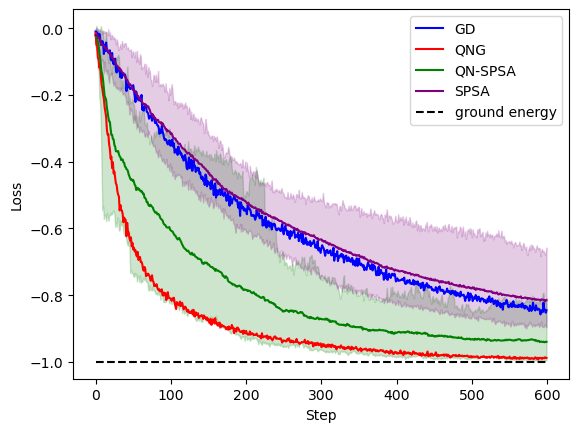

In [10]:
step = range(max_iter)
loss_gd = np.array(results[0]['GD_loss_per_iter'])[0]
loss_qng = np.array(results[1]['QNG_loss_per_iter'])[0]

qnspsa_loss = np.array(results[2]['QNSPSA_loss_per_iter'])
qnspsa_loss_mean = np.mean(qnspsa_loss, axis=0)
qnspsa_loss_max = np.max(qnspsa_loss, axis=0)
qnspsa_loss_min = np.min(qnspsa_loss, axis=0)

spsa_loss = np.array(results[3]['SPSA_loss_per_iter'])
spsa_loss_mean = np.mean(spsa_loss, axis=0)
spsa_loss_max = np.max(spsa_loss, axis=0)
spsa_loss_min = np.min(spsa_loss, axis=0)

ground_energy = -np.ones(max_iter)

fig, ax = plt.subplots()

ax.plot(
    step, loss_gd, 'b', 
    step, loss_qng, 'r', 
    step, qnspsa_loss_mean, 'g',
    step, spsa_loss_mean, 'purple',
)

ax.plot(step, ground_energy, linestyle='dashed', color='k')

ax.fill_between(step, qnspsa_loss_min, qnspsa_loss_max, color='g', alpha=.2)
ax.fill_between(step, spsa_loss_min, spsa_loss_max, color='purple', alpha=.2)
ax.legend(['GD', 'QNG', 'QN-SPSA', 'SPSA', 'ground energy'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

The above plot shows how the loss drops over optimization steps. The purple/green solid line represents the average of the 25 curves for SPSA/QN-SPSA. The purple/green shaded area stands for the envelope of all 25 curves for SPSA/QN-SPSA. 

The results are well aligned with the observations from Gacon et al. [1]. In this example with a rather simple energy landscape, the average behavior of SPSA matches the one from GD. QNG performs the best among the 4 candidates, however, requires the most circuit executions and shots per step. In particular for QPUs this is a severe disadvantage of this method. From the more shot-frugal options, QN-SPSA demonstrates the fastest convergence and best final accuracy, making it a promising candidate for variational algorithms. 

From the step-wise optimization time, we can see the advantage of the stochastic optimizers (SPSA, QN-SPSA) over the analytical ones (GD, QNG). Note that this advantage will become more prominent with larger and more complicated circuits, as we will see in the next section when benchmarking with QAOA.

In [11]:
print(f'GD takes %.2f s per step' % (results[0]['GD_duration'] / repeats[0] / max_iter))
print(f'QNG takes %.2f s per step' % (results[1]['QNG_duration'] / repeats[1] / max_iter))
print(f'QNSPSA takes %.2f s per step' % (results[2]['QNSPSA_duration'] / repeats[2] / max_iter))
print(f'SPSA takes %.2f s per step' % (results[3]['SPSA_duration'] / repeats[3] / max_iter))

GD takes 0.43 s per step
QNG takes 0.75 s per step
QNSPSA takes 0.20 s per step
SPSA takes 0.03 s per step


## Benchmarking with QAOA
As we know from the [no-free-lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem), there is no universal optimizer that suits every problem. Lets take a look at the QN-SPSA optimizer in the context of QAOA problems, and analyze it's performance for this important class of problems.

We now perform the benchmarking with QAOA on the four optimizers. To make sure that the results are reproducible, we can save a copy of the parameter initialization result with the following cell. 

In [12]:
n_qubits = 10
depth = 2

params_init = 2 * np.pi * (np.random.rand(2, depth) - 0.5) 
   
np.save(
    f"source_scripts/qaoa_params_init_{n_qubits}_qubits_{depth}_layers.npy", 
    params_init
)

As before, we provide you with the code to run this benchmark in the script `source_scripts/benchmark_qaoa_converge_speed`, so you can readily reproduce the results using Hybrid Jobs. The problem graph is defined with a node number of `n_qubits`, an edge number of `edges`, and a `seed` value. We have selected a fixed learning rate for each optimizer based on experience. In a real world experiment, you would fine tune each method during hyperparameter optimization, which goes beyond the scope of this example.  The following two cells take about 60 min to finish.

In [13]:
# The execution time of the job is about 60 min, and charges about $0.25.
# Feel free to uncomment the cell to run.

"""
n_qubits = 10
optimizers = ["GD", "QNG", "QNSPSA", "SPSA"]
repeats = [1, 1, 20, 20]
learn_rates = [1e-2, 5e-2, 0.1, 2e-2]

hyperparameters = {
    "n_qubits": n_qubits,
    "edges": 20,
    "depth": 2,
    "shots": 8192,
    "seed": 198, # random seed for graph generation
    "load_init_config": True,
    "max_iter": 400,
}

max_iter = hyperparameters["max_iter"]

jobs = []
for i in range(len(optimizers)):
    hyperparameters["spsa_repeats"] = repeats[i]
    hyperparameters["optimizer"] = optimizers[i]
    hyperparameters["learn_rate"] = learn_rates[i]

    job_name = f"qaoa-benchmark-qubit{n_qubits}-opt{optimizers[i]}" + str(int(time.time()))
    instance_config = InstanceConfig(instanceType='ml.m5.large', volumeSizeInGb=30, instanceCount=1)

    job = AwsQuantumJob.create(
        device="local:pennylane/lightning.qubit",
        source_module="source_scripts",
        entry_point="source_scripts.benchmark_qaoa_converge_speed",
        job_name=job_name,
        hyperparameters=hyperparameters,
        instance_config=instance_config,
        image_uri=image_uri,
        wait_until_complete=False,
    )
    jobs.append(job)
"""

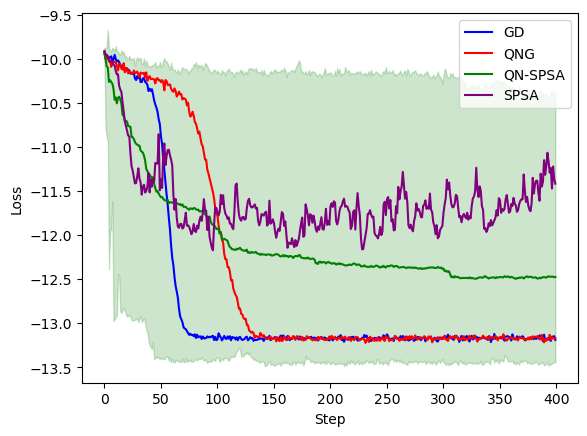

In [14]:
results = [job.result() for job in jobs]
step = range(max_iter)
loss_gd = np.array(results[0]['GD_loss_per_iter'])[0]
loss_qng = np.array(results[1]['QNG_loss_per_iter'])[0]

qnspsa_loss = np.array(results[2]['QNSPSA_loss_per_iter'])
qnspsa_loss_mean = np.mean(qnspsa_loss, axis=0)
qnspsa_loss_max = np.max(qnspsa_loss, axis=0)
qnspsa_loss_min = np.min(qnspsa_loss, axis=0)

spsa_loss = np.array(results[3]['SPSA_loss_per_iter'])
spsa_loss_mean = np.mean(spsa_loss, axis=0)
spsa_loss_max = np.max(spsa_loss, axis=0)
spsa_loss_min = np.min(spsa_loss, axis=0)


fig, ax = plt.subplots()

ax.plot(
    step, loss_gd, 'b', 
    step, loss_qng, 'r', 
    step, qnspsa_loss_mean, 'g',
    step, spsa_loss_mean, 'purple',
)

ax.fill_between(step, qnspsa_loss_min, qnspsa_loss_max, color='g', alpha=.2)
#ax.fill_between(step, spsa_loss_min, spsa_loss_max, color='purple', alpha=.2)
ax.legend(['GD', 'QNG', 'QN-SPSA', 'SPSA'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

GD, QNG and QN-SPSA are able to minimize the loss function to be below -13, giving an estimated ground state of -14 for the max cut problem compared to the true ground state energy of -16. As before, GD and QNG seem to outperform QN-SPSA when considering step-wise convergence. However, each step in GD and QNG require significantly more circuit executions compared to the stochastic QN-SPSA. Let's have a closer look at that.

When we look at the time per step in our simulations, we can clearly see signals that GD and QNG are more expensive on a per-step basis.

In [15]:
print(f'GD takes %.2f s per step' % (results[0]['GD_duration'] / repeats[0] / max_iter))
print(f'QNG takes %.2f s per step' % (results[1]['QNG_duration'] / repeats[1] / max_iter))
print(f'QNSPSA takes %.2f s per step' % (results[2]['QNSPSA_duration'] / repeats[2] / max_iter))
print(f'SPSA takes %.2f s per step' % (results[3]['SPSA_duration'] / repeats[3] / max_iter))

GD takes 4.05 s per step
QNG takes 4.73 s per step
QNSPSA takes 0.42 s per step
SPSA takes 0.19 s per step


The reason of the long optimization time per step for GD and QNG to optimize per step is in the gradient computation. The analytical optimizers (QNG, GD) compute gradients via the parameter shift rule, which requires executing 2$n_G$ circuits, where $n_G$ is the parameterized gate number. QAOA ansatz has only $2p$ parameters, but a rather large amount of parameterized gates. On the other hand, stochastic methods (QN-SPSA, SPSA) always execute a fixed number of circuits for each step, independent of the problem size. 

## Scaling up: QN-SPSA on larger problems

The behavior and performance of different optimizers depend strongly on the problem instance and, in particular, the problem size.  As we have seen above, analytical gradient estimation, such as employed in GD and QNG quickly become impractical when the system size gets larger, due to the increasing number tasks and shots that are required to calculate the gradient. Stochastic optimizers, such as QN-SPSA are designed to overcome this challenge. Let's take a look how QN-SPSA performs as we go to larger system sizes. In the following cells, we simulate a larger QAOA graph with 29 nodes and 58 edges. We use PennyLane's GPU simulator `lightning.gpu` for this workload, as it provides up to 10X speedup for intermediate scale problems (problems with 20-29 qubits). Before you run the cell, note that QN-SPSA takes 3.5 min per step, and about 3.5 hours overall to finish the algorithm.

**Note:** The following cell may be unable to complete with the default resource limits. You may contact [AWS Support](https://support.console.aws.amazon.com/support/home#/case/create?issueType=service-limit-increase) to increase the limits on your account.

In [16]:
# The execution time of the job is about 3.5 hours, and charges about $13.
# Feel free to uncomment the cell to run.

"""
# select the PL_PYTORCH container, which supports lightning.gpu simulator
image_uri = retrieve_image(Framework.PL_PYTORCH, region_name)
n_qubits = 29
edges = 2 * n_qubits
hyperparameters = {
    "n_qubits": n_qubits,
    "edges": edges,
    "depth": 2,
    "shots": 8192,
    "seed": 197,
    "load_init_config": False,
    "max_iter": 60,
    "learn_rate": 1e-2,
}
# ml.p3.2xlarge provides a V100 GPU for the GPU simulator to run
instance_config = InstanceConfig(instanceType='ml.p3.2xlarge', volumeSizeInGb=30, instanceCount=1)

job_name = f"qaoa-large-problem-gpu-qubits{n_qubits}-" + str(int(time.time()))


job = AwsQuantumJob.create(
    device="local:pennylane/lightning.gpu",
    source_module="source_scripts",
    entry_point="source_scripts.qaoa_large_problem",
    job_name=job_name,
    hyperparameters=hyperparameters,
    instance_config=instance_config,
    image_uri=image_uri,
    wait_until_complete=False,
)
"""

Let's take a look at the results:

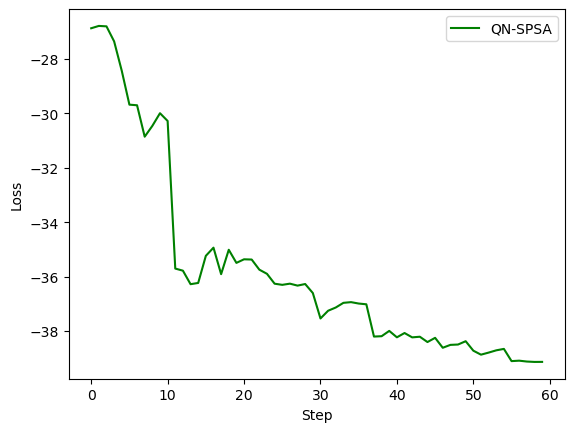

In [17]:
results = job.result()
step = range(60)

loss_qnspsa = results['qnspsa_loss_per_iter']

fig, ax = plt.subplots()

ax.plot(step, loss_qnspsa, 'g',)
ax.legend(['QN-SPSA'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

The QAOA algorithm provides a minimized loss value of -40. To further improve the QAOA solution from here, you can try to increase $p$ from 2 to a larger integer, or experiment with the other hyperparameters. As the simulator's execution time scales roughly linearly with $p$, you should expect a longer run time.

## Embedded simulator vs on-demand simulator

As embedded simulators experience reduced latency, it enable us to run high-performant quantum circuit simulations. With PennyLane's GPU simulator `lightning.gpu`, we are able to run simulation workloads up to 29 qubits, bottlenecked by the single-GPU memory. To go beyond 29 qubits, we can use the CPU simulator `lightning.qubit` on instances with sufficient memory and CPU power. For example, an `ml.m5.24xlarge` instance has 96 vCPUs and 384 GiB of memory, and it is able to simulate circuits up to 34-35 qubits.

On the other hand, On-demand simulators have the [task batching](https://docs.aws.amazon.com/braket/latest/developerguide/braket-batching-tasks.html?tag=local002) feature to run circuit simulation tasks in parallel, which is integrated into PennyLane's `qml.execute()` function. When the quantum algorithm can be efficiently parallelized, we would expect the on-demand simulators to provide a reasonable speedup. 

Note that this speedup from task parallelization is algorithm specific. For QN-SPSA, we have written the optimizer class in a way it can best utilize the task batching. With the SV1 on-demand simulator, the same 29-node-graph QAOA problem has a step-wise optimization time of 3.5 min, similar to the result from the embedded simulator `lightning.gpu`.

# Conclusion

In this notebook, we demonstrate an example of using Braket Jobs and the embedded simulator feature to study a novel optimizer, QN-SPSA. With the example, we demonstrate how to use Hybrid Jobs to accelerate experimentation and research into varitational quantum algorithms, recommend a few best practices, and discuss the advantages and limitations of the embedded simulator.

# References
[1] Gacon, J., Zoufal, C., Carleo, G., & Woerner, S. (2021). *Simultaneous perturbation stochastic approximation of the quantum fisher information*. Quantum, 5, 567.

[2] Simultaneous perturbation stochastic approximation (2022). Wikipedia. https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation

[3] Yamamoto, N. (2019). *On the natural gradient for variational quantum eigensolver*. arXiv preprint arXiv:1909.05074.

[4] Fubini–Study metric (2022). Wikipedia. https://en.wikipedia.org/wiki/Fubini%E2%80%93Study_metric

[5] Stokes, J., Izaac, J., Killoran, N., & Carleo, G. (2020). *Quantum natural gradient*. Quantum, 4, 269.

[6] Farhi, E., Goldstone, J., & Gutmann, S. (2014). *A quantum approximate optimization algorithm*. arXiv preprint arXiv:1411.4028.
  
